## **ANALISIS SENTIMEN PADA APLIKASI DUOLINGO**

## **1. Import Library**

In [1]:
# Data Understanding
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud

# Data Preparation
import string
!pip install -q nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords', quiet=True)
import json
from sklearn.model_selection import train_test_split
!pip install -q tensorflow
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Modelling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Saving
import pickle

## **2. Data Understanding**

### **Load Dataset**

In [2]:
file_id = '1qoIYbFW3dFogTpCj08oKAjbvxiXWlIXC'
file_url = f'https://drive.google.com/uc?id={file_id}'

# Membaca file dataset .csv sebagai Dataframe
duolingo_reviews = pd.read_csv(file_url)

### **Exploratory Data Analysis**

In [3]:
# Melihat 5 data teratas
duolingo_reviews.head()

,content,score,at
0,at first i really love this app. it's cool i c...,3,2025-04-04 10:04:14
1,"I can tell this is AI, dissapointing. It can l...",2,2025-05-23 03:29:43
2,"I really enjoy using this app. However, I beli...",4,2025-06-01 15:31:04
3,New update again. The App is unusable on my Sa...,1,2025-06-05 17:42:06
4,This app focuses more on the competition aspec...,2,2025-06-03 23:28:27


In [4]:
duolingo_reviews.info()  # Melihat informasi struktur dataframe duolingo_reviews untuk memahami bentuk dan isinya, terutama struktur kolom dan tipe datanya.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   score    20000 non-null  int64 
 2   at       20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


In [5]:
duolingo_reviews.describe() # Melihat karaktertistik statistik dataframe

,score
count,20000.00000
mean,3.14455
std,1.61737
min,1.00000
25%,1.00000
50%,3.00000
75%,5.00000
max,5.00000


In [6]:
# Rentang waktu ulasan diberikan
duolingo_reviews['at'] = pd.to_datetime(duolingo_reviews['at'])
min_date = duolingo_reviews['at'].min().strftime('%Y-%m-%d')
max_date = duolingo_reviews['at'].max().strftime('%Y-%m-%d')

print(f"Rentang tanggal ulasan: Dari {min_date} sampai {max_date}")

Rentang tanggal ulasan: Dari 2024-08-21 sampai 2025-06-12


### **Data Cleaning**

In [7]:
# Menampilkan jumlah baris sebelum menghapus missing values (data yang hilang)
print("Jumlah baris sebelum menghapus missing values:", len(duolingo_reviews))

# Menghapus baris yang memiliki missing values (data yang hilang) di kolom penting
duolingo_reviews_cleaned = duolingo_reviews.dropna(subset=['content', 'score'])

# Menampilkan jumlah baris setelah menghapus missing values (data yang hilang)
print("Jumlah baris setelah menghapus missing values:", len(duolingo_reviews_cleaned))

Jumlah baris sebelum menghapus missing values: 20000
Jumlah baris setelah menghapus missing values: 20000


In [8]:
# Menampilkan jumlah baris sebelum menghapus duplikat
print("Jumlah baris sebelum menghapus duplikat:", len(duolingo_reviews))

# Menghapus baris duplikat
duolingo_reviews_cleaned = duolingo_reviews.drop_duplicates()

# Menampilkan jumlah baris setelah menghapus duplikat
print("Jumlah baris setelah menghapus duplikat:", len(duolingo_reviews_cleaned))

Jumlah baris sebelum menghapus duplikat: 20000
Jumlah baris setelah menghapus duplikat: 20000


### **Data Visualization**

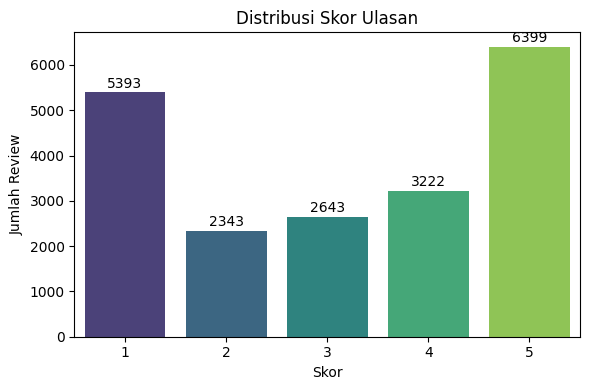

In [9]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=duolingo_reviews_cleaned, x='score', order=[1, 2, 3, 4, 5], palette='viridis')

# Menambahkan label jumlah review di atas setiap bar (batang)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100,
            int(height),
            ha="center", fontsize=10)

# Menambahkan judul grafik
plt.title('Distribusi Skor Ulasan')

# Menambahkan label pada sumbu x dan y
plt.xlabel('Skor')
plt.ylabel('Jumlah Review')

# Menyesuaikan layout agar lebih rapat
plt.tight_layout()

# Menampilkan grafik
plt.show()

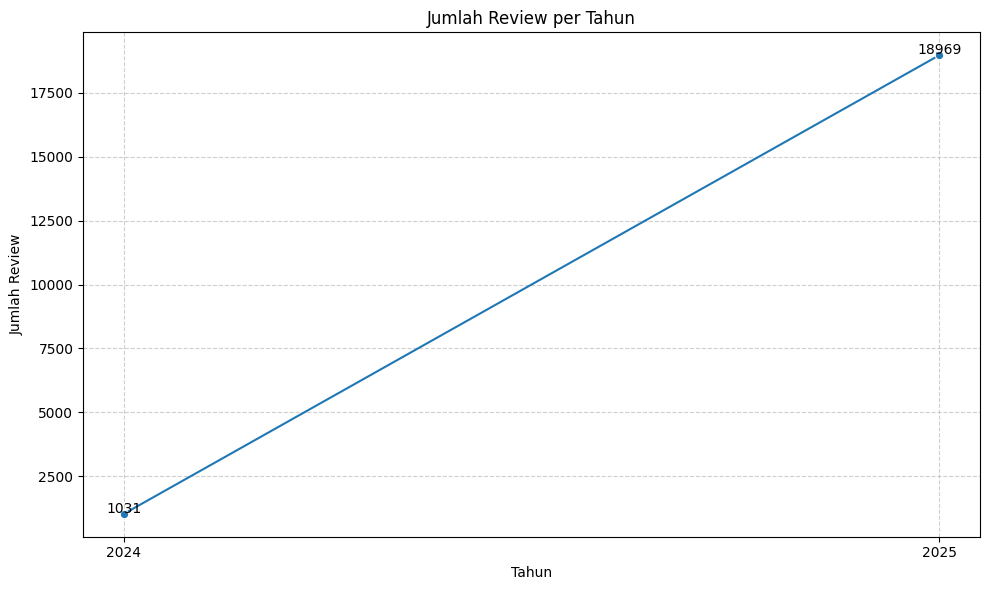

In [10]:
# Konversi kolom 'at' menjadi tipe datetime
duolingo_reviews_cleaned['at'] = pd.to_datetime(duolingo_reviews_cleaned['at'])

# Ekstrak tahun dari kolom 'at' dan buat kolom baru 'year'
duolingo_reviews_cleaned['year'] = duolingo_reviews_cleaned['at'].dt.year

# Hitung jumlah review per tahun
reviews_per_year = duolingo_reviews_cleaned['year'].value_counts().sort_index()

# Membuat visualisasi jumlah review per tahun
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x=reviews_per_year.index, y=reviews_per_year.values, marker='o')

# Menambahkan judul dan label sumbu
plt.title('Jumlah Review per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Review')
plt.xticks(reviews_per_year.index) # Set x-ticks ke tahun yang ada

# Menambahkan jumlah review di atas setiap titik data
for year, count in reviews_per_year.items():
    ax.text(year, count + 50, count, ha='center')

# Menampilkan grafik
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

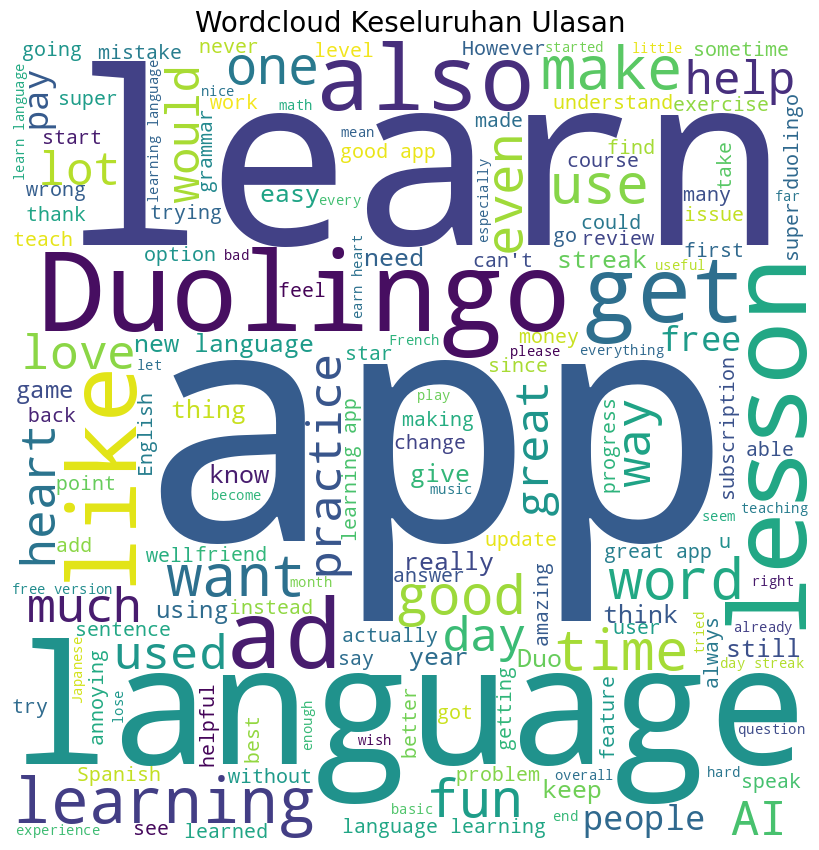

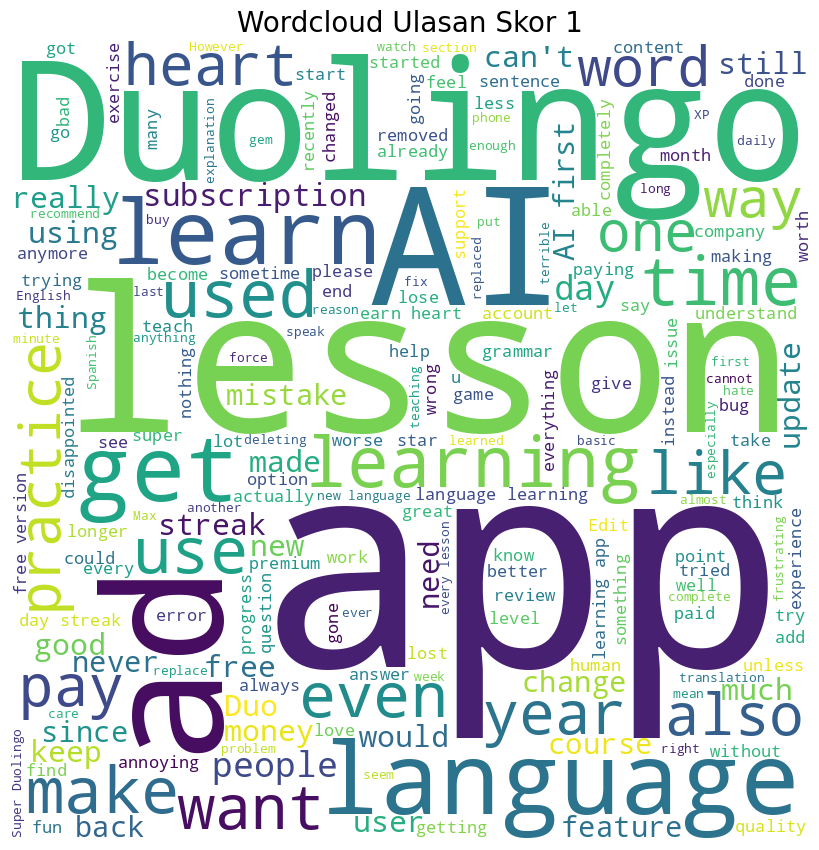

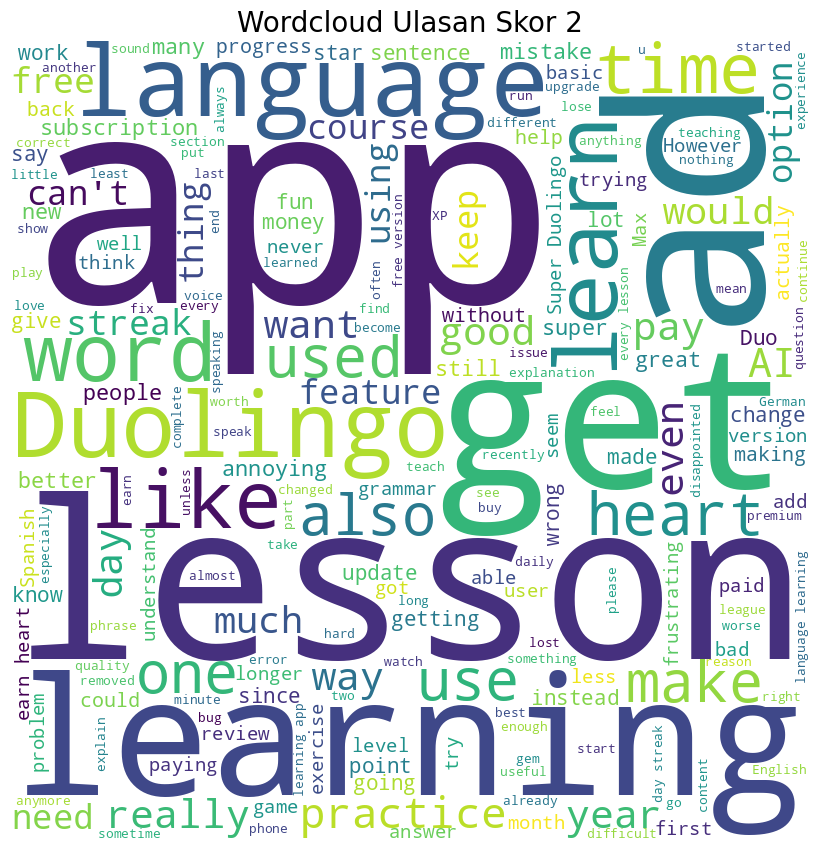

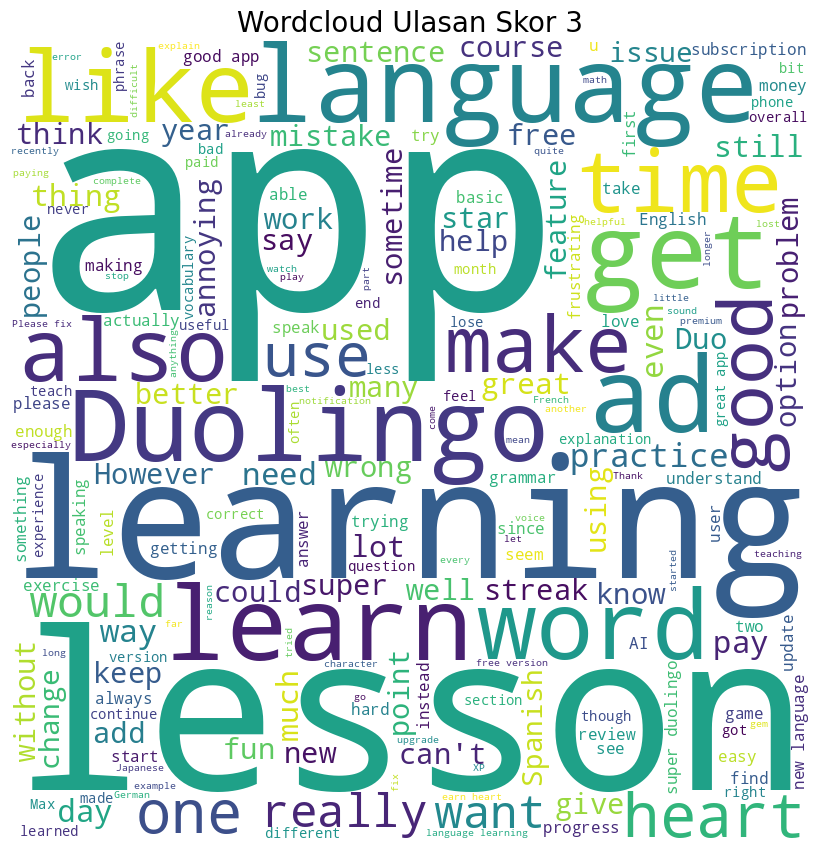

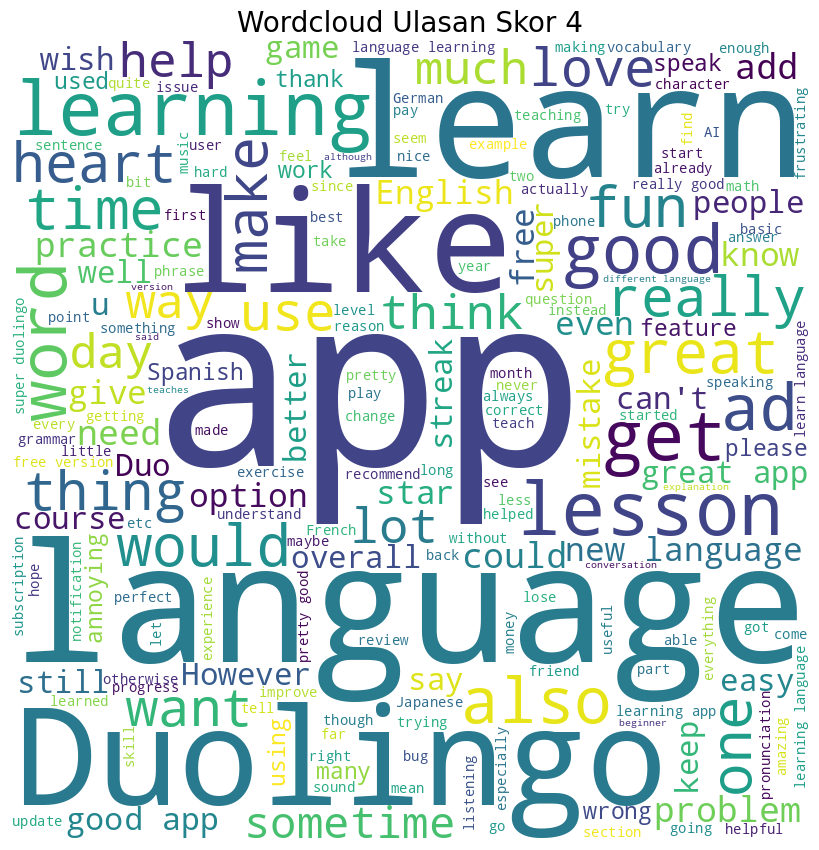

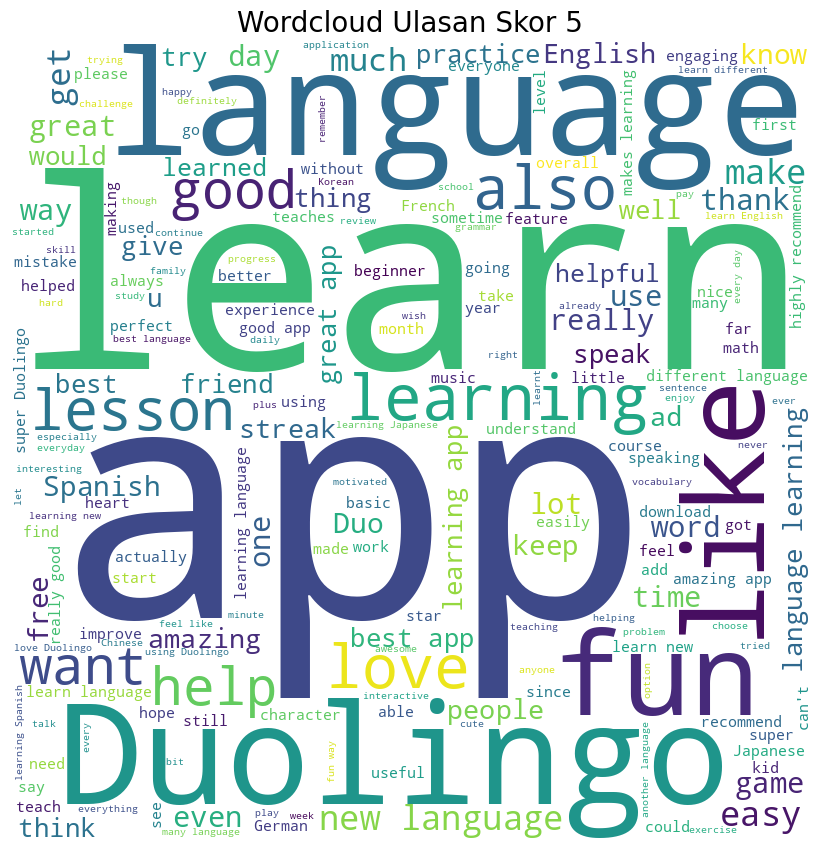

In [11]:
# Menggabungkan semua ulasan untuk setiap skor rating
all_reviews = " ".join(duolingo_reviews_cleaned['content'])

# Fungsi untuk membuat dan menampilkan wordcloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          stopwords = stopwords.words('english'),
                          min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title, fontsize=20)
    plt.show()

# Wordcloud keseluruhan
generate_wordcloud(all_reviews, 'Wordcloud Keseluruhan Ulasan')

# Wordcloud untuk setiap skor rating
for score in sorted(duolingo_reviews_cleaned['score'].unique()):
    reviews_by_score = " ".join(duolingo_reviews_cleaned[duolingo_reviews_cleaned['score'] == score]['content'])
    generate_wordcloud(reviews_by_score, f'Wordcloud Ulasan Skor {score}')

## **3. Data Preparation**

### **Preprocessing**

In [12]:
# Mendefinisikan kamus slang
slang_dict = {
  "ffs": "frustrated",
  "wtf": "crazy",
  "wth": "crazy",
  "what the hell": "crazy",
  "what the fuck": "crazy",
  "idk": "confused",
  "ikr": "agree",
  "smh": "disappointed",
  "avg": "average",
  "omg": "surprised",
  "lmao": "funny",
  "lol": "funny",
  "btw": "by the way",
  "anw": "anyway",
  "imo": "in my opinion",
  "idc": "don't care",
  "nah": "no",
  "yea": "yes",
  "bruh": "seriously",
  "buggy": "error",
  "glitchy": "error",
  "crashy": "error",
  "laggy": "slow",
  "ux": "user experience",
  "ui": "interface",
  "pls": "please",
  "devs": "developers",
  "acc": "account",
  "login": "log in",
  "logout": "log out",
  "signup": "sign up",
  "signin": "sign in",
  "xp": "points",
  "lingots": "rewards",
  "crashing": "error",
  "bs": "nonsense",
  "super": "very",
  "meh": "uninterested",
  "newbie": "beginner",
  "noob": "beginner",
  "ugh": "annoyed",
  "damn": "frustrated",
  "dope": "cool",
  "lit": "amazing",
  "cringe": "embarrassing",
  "sucks": "bad",
  "kinda": "somewhat",
  "hella": "very",
  "rip": "sad",
  "gg": "impressive",
  "trash": "low quality",
  "fire": "great",
  "mid": "mediocre",
  "sus": "suspicious",
  "fs": "surely",
  "for sure": "surely",
  "fr": "for real",
  "cap": "lie",
  "no cap": "truth",
  "banger": "amazing content",
  "af": "very",
  "jk": "just kidding",
  "ngl": "honestly",
  "fomo": "fear of missing out",
  "grind": "effort",
  "w": "win",
  "l": "loss",
  "wtv": "whatever",
  "gr8": "great",
  "thx": "thanks",
  "ty": "thank you",
  "np": "no problem",
  "idgaf": "don't care",
  "rofl": "funny",
  "brb": "be right back",
  "bff": "close friend",
  "irl": "in real life",
  "wyd": "what are you doing",
  "tbh": "to be honest",
  "fyi": "for your information",
  "gtg": "got to go",
  "smth": "something",
  "tho": "though",
  "bcz": "because",
  "bc": "because",
  "bcs": "because",
  "prob": "problem",
  "probz": "probably",
  "probs": "probably",
  "ya": "yes",
  "nahh": "no",
  "okie": "okay",
  "oke": "okay",
  "ok": "okay",
  "cs": "customer service",
  "lmk": "let me know",
  "lowkey": "slightly",
  "lowk": "slightly",
  "highkey": "obviously",
  "annoying af": "very annoying",
  "lag af": "very slow",
  "trash": "bad",
  "ig": "uncertain",
  "not gonna lie": "honestly",
  "no lie": "honestly",
  "shit": "",
  "fuck": "",
  "fucking": "",
  "fuckin": "",
  "fucked": "",
  "fucked up": "ruined",
  "bitch": "",
  "ass": "terrible",
  "asshole": "",
  "bastard": "",
  "dumb": "terrible",
  "idiot": "",
  "stupid": "terrible",
  "crap": "terrible",
  "bullshit": "terrible",
  "damn": "",
  "hell": "",
  "goated": "amazing",
  "nvm": "never mind",
  "afaik": "as far as I know",
  "asap": "as soon as possible",
  "welp": "disappointed",
  "oop": "surprised",
  "on point": "accurate",
  "yeah": "yes",
  "definetly": "definitely",
  "wierd": "weird",
  "recieve": "receive",
  "finaly": "finally",
  "freind": "friend",
  "embarasing": "embarassing",
  "happend": "happened",
  "happends": "happens",
  "adress": "address",
  "addres": "address",
  "dificult": "difficult",
  "recomend": "recommend",
  "recomended": "recommended",
  "recomending": "recommending",
  "recomends": "recommends",
  "disapoint": "disappoint",
  "disapointed": "disappointed",
  "disapointing": "disappointing",
  "disapointment": "disappointment",
  "dissapointing": "disappointing",
  "dissappointing": "disappointing",
  "dissapoint": "disappoint",
  "dissappoint": "disappoint",
  "dissapointment": "disappointment",
  "dissappointment": "disappointment",
  "dissappointed": "disappointed",
  "dissapointed": "disappointed",
  "slaps": "awesome",
  "bomb": "awesome",
  "chef’s kiss": "perfect",
  "peak": "amazing",
  "next level": "amazing",
  "deadass": "seriously",
  "on god": "seriously",
  "ate": "did good",
  "ate that": "did good",
  "serving": "performing well",
  "slay": "amazing",
  "yikes": "terrible",
  "ew": "bad",
  "eww": "bad",
  "ewww": "bad",
  "ewwww": "bad",
  "wack": "terrible",
  "freak": "weird",
  "freaking": "very",
  "freakin": "very",
  "freaky": "weird",
  "flop": "failure",
  "what the heck": "crazy",
  "heck": "crazy",
  "damnit": "frustrated",
  "darn": "frustrated",
  "eh": "uninterested",
  "wild": "crazy",
  "gas": "amazing",
  "gassed": "excited",
  "bussin": "amazing",
  "dogshit": "terrible",
  "busted": "broken",
  "duo": "duolingo character",
  "lily": "duolingo character",
  "zari": "duolingo character",
  "bea": "duolingo character",
  "lin": "duolingo character",
  "lucy": "duolingo character",
  "oscar": "duolingo character",
  "eddy": "duolingo character",
  "junior": "duolingo character",
  "vikram": "duolingo character",
  "falstaff": "duolingo character",
  "super duolingo": "premium",
  "duolingo max": "premium",
  "dunno": "confused",
  "pronounciation": "pronunciation",
  "etc": "and so on",
  "aka": "also known as",
  "eg": "for example",
  "ie": "",
  "number one": "favorite",
  "duo plus": "premium"
}

# Menyimpan file .json
with open('slangwords.json', 'w') as f:
    json.dump(slang_dict, f, indent=4)

print("File 'slangwords.json' berhasil dibuat.")

File 'slangwords.json' berhasil dibuat.


In [13]:
# Load kamus slang
with open('slangwords.json', 'r') as f:
    slang_dict = json.load(f)

# Inisialisasi stopwords dan stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def full_preprocess(text):
    # 1. Case folding
    text = text.lower()

    # 2. Hapus URL
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # 3. Hapus angka
    text = re.sub(r'\d+', '', text)

    # 4. Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 5. Normalization
    for slang, replacement in slang_dict.items():
        text = re.sub(r'\b' + re.escape(slang) + r'\b', replacement, text)

    # 6. Hapus white space berlebih
    text = text.strip()

    # 7. Tokenisasi
    tokens = text.split()

    # 8. Stopwords removal
    tokens = [word for word in tokens if word not in stop_words]

    # 9. Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # 10. Gabungkan kembali jadi string
    return ' '.join(tokens)

In [14]:
duolingo_reviews_cleaned['preprocessed_reviews'] = duolingo_reviews_cleaned['content'].apply(full_preprocess) # Menerapkan preprocessing

In [15]:
duolingo_reviews_cleaned # Melihat data setelah preprocessing

,content,score,at,year,preprocessed_reviews
0,at first i really love this app. it's cool i c...,3,2025-04-04 10:04:14,2025,first realli love app cool learn lot languag e...
1,"I can tell this is AI, dissapointing. It can l...",2,2025-05-23 03:29:43,2025,tell ai disappoint lack context explan look go...
2,"I really enjoy using this app. However, I beli...",4,2025-06-01 15:31:04,2025,realli enjoy use app howev believ there’ still...
3,New update again. The App is unusable on my Sa...,1,2025-06-05 17:42:06,2025,new updat app unus samsung phone fill answer f...
4,This app focuses more on the competition aspec...,2,2025-06-03 23:28:27,2025,app focus competit aspect daili competit teach...
...,...,...,...,...,...
19995,words can't describe how helpful this app has ...,5,2025-01-02 21:20:51,2025,word cant describ help app teach languag teach...
19996,The way the app has changed to make the free u...,2,2025-01-11 12:31:29,2025,way app chang make free use come advert everi ...
19997,This app has gotten way too expensive when rea...,3,2025-02-15 03:52:34,2025,app gotten way expens realli includ pay practi...
19998,Duolingo is amazing !! i've been learning span...,5,2025-01-13 16:18:33,2025,duolingo amaz ive learn spanish realli easi wo...


### **Labelling**

In [16]:
# Melihat isi reviews dengan rating = 3 sebanyak 20 sampel
pd.set_option('display.max_colwidth', None)
print(duolingo_reviews_cleaned[duolingo_reviews_cleaned['score'] == 3]['content'].sample(20))
pd.reset_option('display.max_colwidth')

343         WORST thing about this app: the INSIPID 15 second ad for Super Duolingo after every. single. lesson. There is also an ad before it that you can skip after 5 seconds. I'd rather have 2 normal ads than the 15s Duolingo ad. I finish a lesson in ~100 seconds, so 20s of ad REALLY slow down my progress. Plus in the unpaid version, you get 5 hearts and if you make 5 mistakes, you're done for the day. Which seems self defeating cause then they can't feed you more ads. all that aside, it's effective
672                                                                                                                                 This used to be a great app for learning. Ever since the recent update, my progress has gone downhill. I'm not sure the reason for this horrible change to the app, but stick to what was working, or at least give people the option to go back to the older version. Also, this running out of "hearts" and having to get a refill for 450 whatever they are is comple

In [17]:
# Mendefinisikan label sentimen pada ulasan

# Ubah label ke 2 kelas: 0 = negatif, 1 = positif
def label_sentiment(score):
    if score <= 3:
        return 0  # negatif
    else:
        return 1  # positif

# Terapkan ke data
duolingo_reviews_cleaned['label'] = duolingo_reviews_cleaned['score'].apply(label_sentiment)

# Cek distribusi label
print(duolingo_reviews_cleaned['label'].value_counts())

label
0    10379
1     9621
Name: count, dtype: int64


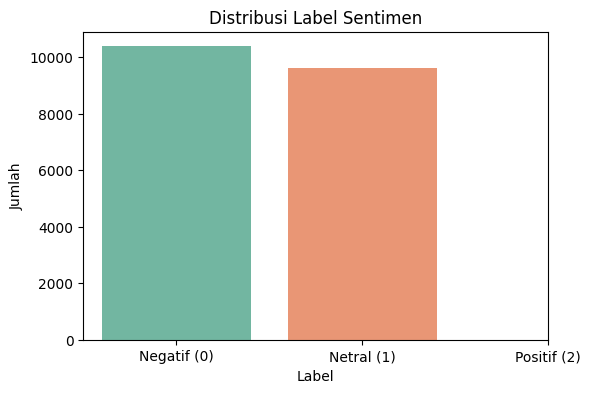

In [18]:
# Visualisasi distribusi label
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=duolingo_reviews_cleaned, palette='Set2')
plt.title('Distribusi Label Sentimen')
plt.xticks([0, 1, 2], ['Negatif (0)', 'Netral (1)', 'Positif (2)'])
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

In [19]:
duolingo_reviews_cleaned # Melihat data setelah Labelling

,content,score,at,year,preprocessed_reviews,label
0,at first i really love this app. it's cool i c...,3,2025-04-04 10:04:14,2025,first realli love app cool learn lot languag e...,0
1,"I can tell this is AI, dissapointing. It can l...",2,2025-05-23 03:29:43,2025,tell ai disappoint lack context explan look go...,0
2,"I really enjoy using this app. However, I beli...",4,2025-06-01 15:31:04,2025,realli enjoy use app howev believ there’ still...,1
3,New update again. The App is unusable on my Sa...,1,2025-06-05 17:42:06,2025,new updat app unus samsung phone fill answer f...,0
4,This app focuses more on the competition aspec...,2,2025-06-03 23:28:27,2025,app focus competit aspect daili competit teach...,0
...,...,...,...,...,...,...
19995,words can't describe how helpful this app has ...,5,2025-01-02 21:20:51,2025,word cant describ help app teach languag teach...,1
19996,The way the app has changed to make the free u...,2,2025-01-11 12:31:29,2025,way app chang make free use come advert everi ...,0
19997,This app has gotten way too expensive when rea...,3,2025-02-15 03:52:34,2025,app gotten way expens realli includ pay practi...,0
19998,Duolingo is amazing !! i've been learning span...,5,2025-01-13 16:18:33,2025,duolingo amaz ive learn spanish realli easi wo...,1


### **Data Splitting**

In [20]:
# Memisahkan fitur (X) dan label (y)
X = duolingo_reviews_cleaned['preprocessed_reviews']
y = duolingo_reviews_cleaned['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 16000, Test size: 4000


### **Tokenizing & Padding**

In [21]:
# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Konversi ke sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding (agar panjang sama)
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

### **Output: Preprocessing & Tokenizing**

In [22]:
example = "I love Duolingo but I find the recent update lowkey terrifying so this is a disapointment"

cleaned = full_preprocess(example)

# Konversi ke sequence
seq = tokenizer.texts_to_sequences([cleaned])
print(f"Teks yang sudah dibersihkan: {cleaned}")
print(f"Token hasil tokenizer: {seq}")

Teks yang sudah dibersihkan: love duolingo find recent updat slightli terrifi disappoint
Token hasil tokenizer: [[30, 5, 119, 135, 54, 1402, 3391, 166]]


## **4. Modelling**

In [23]:
# Membangun arsitektur model LSTM untuk klasifikasi 2 kelas (negatif/positif)
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Menyusun model: menggunakan binary_crossentropy karena klasifikasi 2 kelas
model.build(input_shape=(None, max_len))  # Tentukan bentuk input
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Menampilkan ringkasan arsitektur model (jumlah parameter, layer, output shape)
model.summary()

# Callback EarlyStopping: hentikan training jika tidak ada peningkatan loss validasi selama 5 epoch
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Melatih model dengan data pelatihan yang sudah diproses dan dipad
history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,649 (6.51 MB)

 Trainable params: 1,707,649 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7807 - loss: 0.4557 - val_accuracy: 0.8628 - val_loss: 0.3318
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.8997 - loss: 0.2588 - val_accuracy: 0.8625 - val_loss: 0.3357
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9215 - loss: 0.2141 - val_accuracy: 0.8556 - val_loss: 0.3822
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9470 - loss: 0.1539 - val_accuracy: 0.8472 - val_loss: 0.4230
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9568 - loss: 0.1234 - val_accuracy: 0.8484 - val_loss: 0.4940
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9667 - loss: 0.0993 - val_accuracy: 0.8366 - val_loss: 0.6015


## **5. Evaluation**

### **Akurasi dan Loss pada Data Test**

In [24]:
# Evaluasi skor model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Loss: {loss:.4f}')

Test Accuracy: 0.8733
Test Loss: 0.3183


### **Visualisasi Performa Model: Akurasi dan Loss per Epoch**

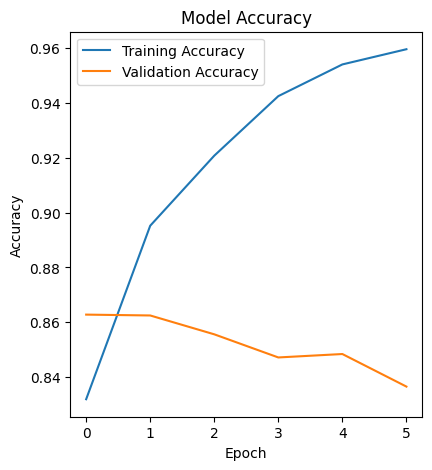

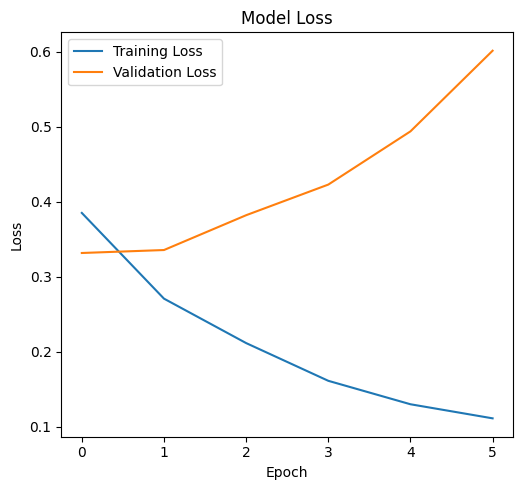

In [25]:
# Plot akurasi pelatihan dan validasi
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss pelatihan dan validasi
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tampilkan plot
plt.tight_layout()
plt.show()

### **Classification Report**

In [26]:
from sklearn.metrics import classification_report

# Prediksi probabilitas pada data test
y_pred_prob = model.predict(X_test_pad)

# Konversi ke label biner: 0 jika ≤ 0.5, 1 jika > 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# Tampilkan classification report
print(classification_report(y_test, y_pred, target_names=['Negatif', 'Positif']))

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

     Negatif       0.88      0.88      0.88      2076
     Positif       0.87      0.87      0.87      1924

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



### **Confusion Matrix**

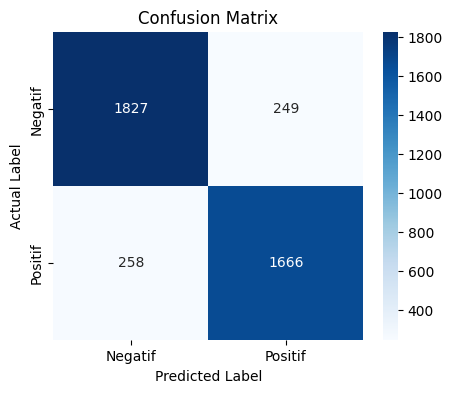

In [27]:
# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

## **Model Saving**

In [28]:
import pickle

# Menyimpan tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Simpan model ke file .keras
model.save('duolingo_sentiment_model.keras')

print("Model berhasil disimpan.")

Model berhasil disimpan.


In [29]:
duolingo_reviews_cleaned.to_csv('clean_duolingo_reviews.csv', index=False)